In [1]:
from unseen import fileio
from unseen import time_utils

You can use the [fileio.open_dataset](https://github.com/AusClimateService/unseen/blob/master/unseen/fileio.py) function to read the data and spatially aggregate to get the Nino 34 index.

In [6]:
help(fileio.open_dataset)

Help on function open_dataset in module unseen.fileio:

open_dataset(infiles, file_format=None, chunks=None, metadata_file=None, variables=[], point_selection=None, lat_bnds=None, lon_bnds=None, shapefile=None, shapefile_label_header=None, shape_overlap=None, combine_shapes=False, spatial_agg='none', lat_dim='lat', lon_dim='lon', agg_y_dim=None, agg_x_dim=None, standard_calendar=False, no_leap_days=False, rolling_sum_window=None, time_freq=None, time_agg=None, time_agg_dates=False, month=None, season=None, reset_times=False, complete_time_agg_periods=False, input_freq=None, time_dim='time', isel={}, sel={}, scale_factors={}, units={}, units_timing='end')
    Create an xarray Dataset from one or more data files.
    
    Parameters
    ----------
    infiles : str or list
        Input file path/s
    file_format : str, optional
        Formats/engines accepted by xarray.open_dataset (e.g. netcdf4, zarr, cfgrid).
        Estimated if not provided.
    chunks : dict, optional
        Chu

In [3]:
ds = fileio.open_dataset(
    '/g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/data/processed/tos_Omon_CanESM5_dcpp.zarr',
    variables=['tos'],
    lat_bnds=[-5, 5],
    lon_bnds=[190, 240],
    spatial_agg='mean',
)

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [4]:
ds

<xarray.Dataset>
Dimensions:  (init: 61, member: 20, lead: 120)
Coordinates:
  * init     (init) object 1961-01-16 12:00:00 ... 2021-01-16 12:00:00
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
    time     (init, lead) object dask.array<chunksize=(61, 120), meta=np.ndarray>
Data variables:
    tos      (init, member, lead) float32 dask.array<chunksize=(61, 20, 120), meta=np.ndarray>

(If the longitude axis was -180 to 180 instead of 0 to 360 you'd need to use `lon_bnds=[-170, -120]`.)

If later on in your workflow you want to calculate the anomaly, the unseen package has a function ([time_utils.anomalise](https://github.com/AusClimateService/unseen/blob/master/unseen/time_utils.py)) to do that easily (because it can be tricky with forecast data that doesn't have a time dimension).

In [7]:
help(time_utils.anomalise)

Help on function anomalise in module unseen.time_utils:

anomalise(ds, clim_period, frequency=None, init_dim='init_date', ensemble_dim='ensemble', time_name='time')
    Calculate anomaly.
    
    Uses a shortcut for calculating hindcast climatologies that will not work
    for hindcasts with initialisation frequencies more regular than monthly.
    
    Parameters
    ----------
    ds : xarray Dataset
        The data to anomalise
    clim_period : iterable
        Size 2 iterable containing strings indicating the start and end dates
        of the climatological period
    frequency : str, optional
        The frequency at which to bin the climatology, e.g. per month. Must be
        an available attribute of the datetime accessor. Specify "None" to
        indicate no frequency (climatology calculated by averaging all times).
        Note, setting to "None" for hindcast data can be dangerous, since only
        certain times may be available at each lead.



For example, to calculate anomalies relative to the monthly 1981-2010 climatology...

In [8]:
ds_anom = time_utils.anomalise(ds, ['1981-01-01', '2010-12-31'], 'month', init_dim='init', ensemble_dim='member')     

In [11]:
ds_anom

<xarray.Dataset>
Dimensions:  (init: 61, lead: 120, member: 20)
Coordinates:
  * init     (init) object 1961-01-16 12:00:00 ... 2021-01-16 12:00:00
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
    time     (init, lead) object dask.array<chunksize=(61, 120), meta=np.ndarray>
Data variables:
    tos      (init, member, lead) float32 dask.array<chunksize=(61, 20, 120), meta=np.ndarray>

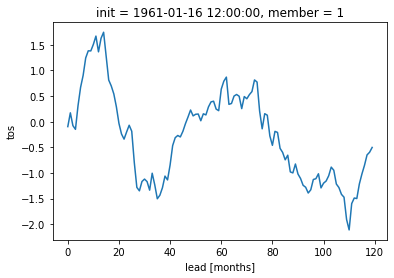

In [13]:
ds_anom['tos'].isel({'init': 0, 'member': 0}).plot()